In [1]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.Gaussian_beam import Guassian_beam
from Props.ASM_Prop import ASM_prop
from Props.RSC_Prop import RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import SoftGumbelQuantizedDOELayerv3 as SoftGumbelQuantizedDOELayer
from Components.QuantizedDOE import NaiveGumbelQuantizedDOELayer
from Components.QuantizedDOE import PSQuantizedDOELayer
from Components.QuantizedDOE import STEQuantizedDOELayer
from Components.QuantizedDOE import FullPrecisionDOELayer
from utils.Helper_Functions import normalize
from utils.units import *
import numpy as np
import scipy.io
import time
import torch.nn as nn

In [2]:
# Hologram parameters (high-temp resin)
epsilon = 2.66
tand = 0.03
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [100, 100]
doe_dxy = 1 * mm
    
    
c0 = 2.998e8
f2 = 300e9  # 0.3 THz

wavelengths = c0 / f2
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 5,
    'look_up_table': None,
    'num_unit': None,
    'height_constraint_max': 1 * mm,
    'tolerance': 0.05 * mm,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 500,
    'tau_max': 6.5,
    'tau_min': 1.0
}

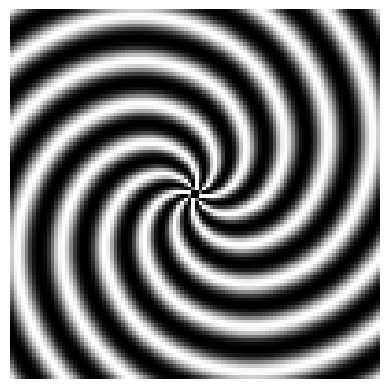

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Set the resolution
resolution = 100

# Create an array of complex numbers
x = np.linspace(-6, 6, resolution)
y = np.linspace(-6, 6, resolution)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Compute the angle and radius of each point
angle = np.angle(Z)
radius = np.abs(Z)

# Generate the spiral pattern
spiral_pattern = np.abs(np.sin(radius*2 + angle * 4))**3

# Plot the image
plt.imshow(spiral_pattern, cmap='gray', extent=(-10, 10, -10, 10))
plt.axis('off')  # Hide axes
plt.show()

torch.Size([1, 1, 100, 100])


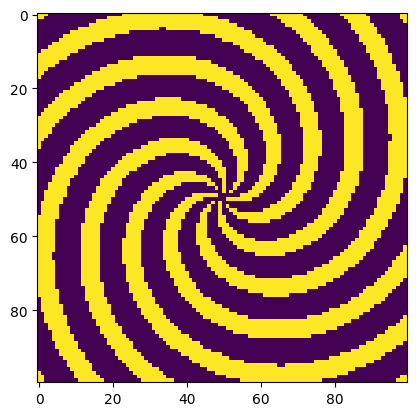

In [4]:
import numpy as np
from PIL import Image
from utils.Helper_Functions import normalize
import matplotlib.pyplot as plt
import torch.nn.functional as F
target1 = torch.tensor(spiral_pattern, dtype=torch.float).unsqueeze(0).unsqueeze(0)
target1 = normalize(target1)
print(target1.shape)
#target1 = F.pad(input=target1, pad=(20, 20, 20, 20), mode='constant', value=0)
target1 = nn.functional.interpolate(torch.round(target1), size=[100, 100])
plt.imshow(target1[0,0,:,:])

# 2. Define the System with SoftGumbelQuantizedDOE 

In [5]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=250 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [6]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [7]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
optimizer = torch.optim.Adam(setup.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4000, gamma=0.1)
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_2, target1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    #scheduler.step()
    if itr % 100 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.35885855555534363
The iteration : 100, Loss: 0.25595155358314514
The iteration : 200, Loss: 0.20460496842861176
The iteration : 300, Loss: 0.18247205018997192
The iteration : 400, Loss: 0.15952220559120178
The iteration : 500, Loss: 0.1521081030368805
The iteration : 600, Loss: 0.137732595205307
The iteration : 700, Loss: 0.13228361308574677
The iteration : 800, Loss: 0.12870991230010986
The iteration : 900, Loss: 0.11913719028234482
The iteration : 1000, Loss: 0.12344833463430405
The iteration : 1100, Loss: 0.11390246450901031
The iteration : 1200, Loss: 0.10924641042947769
The iteration : 1300, Loss: 0.10819872468709946
The iteration : 1400, Loss: 0.10795324295759201
The iteration : 1500, Loss: 0.10445025563240051
The iteration : 1600, Loss: 0.10210058093070984
The iteration : 1700, Loss: 0.101

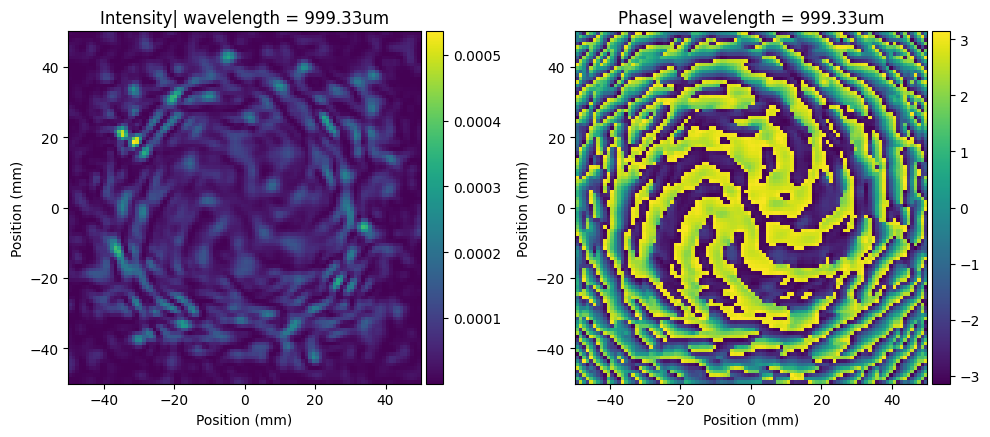

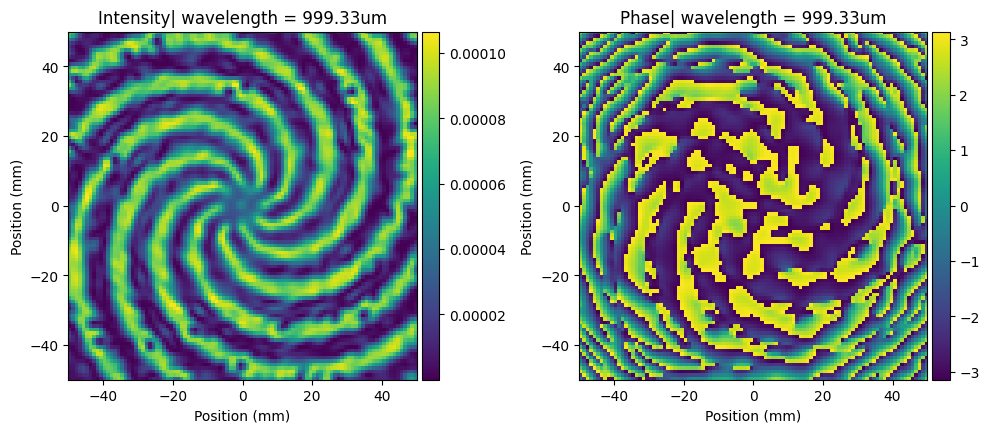

In [8]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

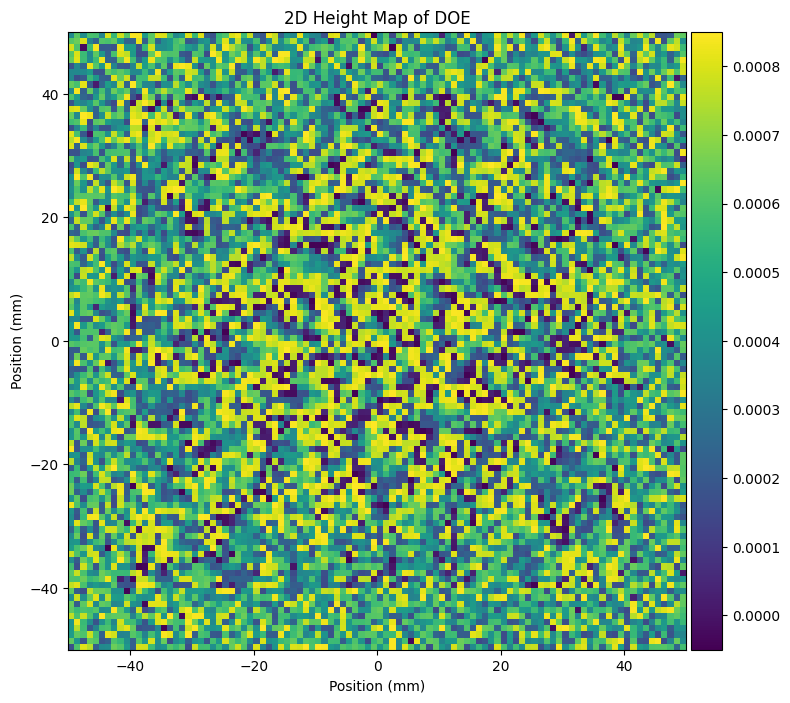

In [9]:
setup.doe.visualize(figsize=(8,8))

# Define the System with FullPrecisionDOE

In [10]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = FullPrecisionDOELayer(self.doe_params)
        

        self.asm_prop3 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=250 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [11]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [12]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
optimizer = torch.optim.Adam(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_2, target1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.375171959400177
The iteration : 200, Loss: 0.20950041711330414
The iteration : 400, Loss: 0.17215648293495178
The iteration : 600, Loss: 0.14840568602085114
The iteration : 800, Loss: 0.15113742649555206
The iteration : 1000, Loss: 0.13444779813289642
The iteration : 1200, Loss: 0.12451476603746414
The iteration : 1400, Loss: 0.11734987795352936
The iteration : 1600, Loss: 0.11108507961034775
The iteration : 1800, Loss: 0.10804765671491623
The iteration : 2000, Loss: 0.10370001941919327
The iteration : 2200, Loss: 0.10861179232597351
The iteration : 2400, Loss: 0.09942752122879028
The iteration : 2600, Loss: 0.10182196646928787
The iteration : 2800, Loss: 0.10067647695541382
The iteration : 3000, Loss: 0.09427157789468765
The iteration : 3200, Loss: 0.1032312735915184
The iteration : 3400, Loss: 

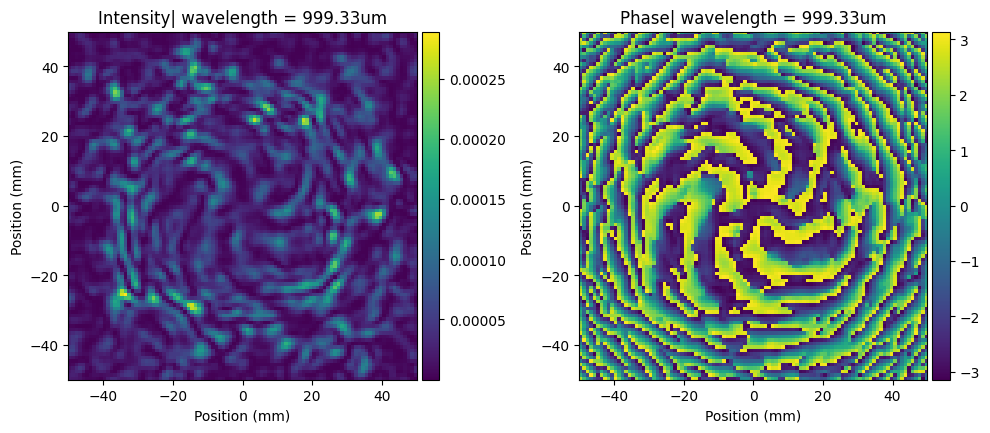

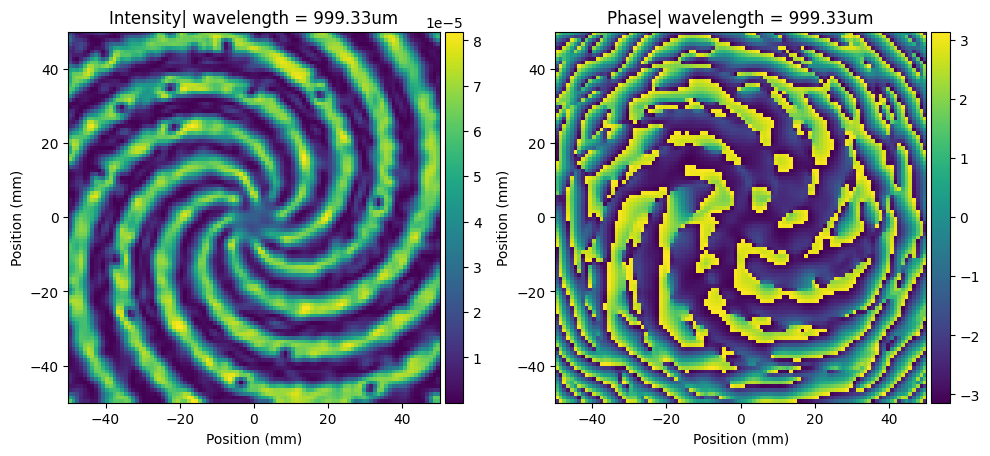

In [13]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

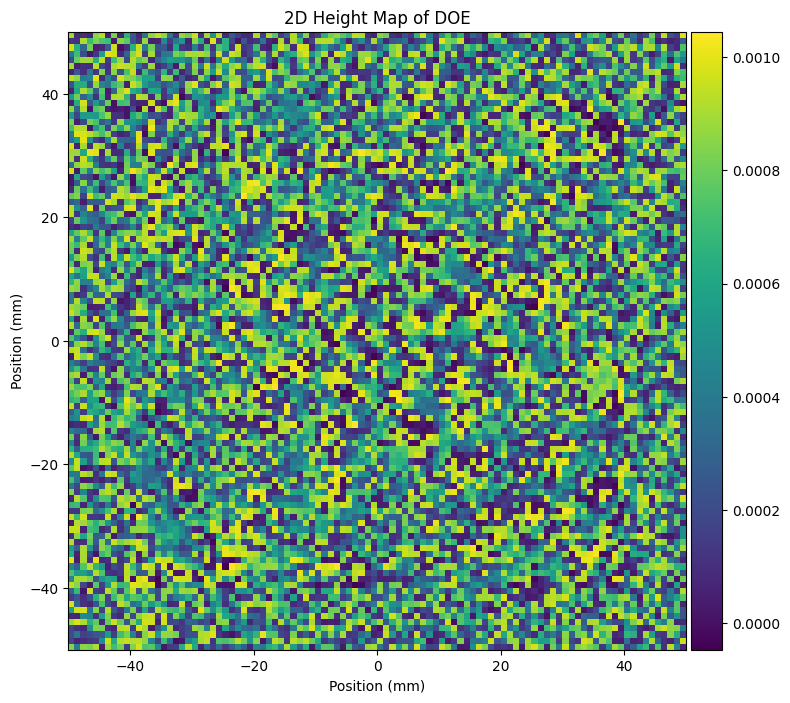

In [14]:
setup.doe.visualize(figsize=(8,8))

# 4. System with NaiveGumbelQuantizedDOELayer

In [15]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = NaiveGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=250 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [16]:
optim_params = {
    'c_s': 500,
    'tau_max': 5.5,
    'tau_min': 1.0
}

setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [17]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
optimizer = torch.optim.Adam(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_2, target1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.36198022961616516
The iteration : 200, Loss: 0.3451294004917145
The iteration : 400, Loss: 0.32624372839927673
The iteration : 600, Loss: 0.31443870067596436
The iteration : 800, Loss: 0.31522172689437866
The iteration : 1000, Loss: 0.3061967194080353
The iteration : 1200, Loss: 0.29206928610801697
The iteration : 1400, Loss: 0.28207480907440186
The iteration : 1600, Loss: 0.2615838348865509
The iteration : 1800, Loss: 0.2680087685585022
The iteration : 2000, Loss: 0.26731497049331665
The iteration : 2200, Loss: 0.25945204496383667
The iteration : 2400, Loss: 0.24250556528568268
The iteration : 2600, Loss: 0.21544614434242249
The iteration : 2800, Loss: 0.20753081142902374
The iteration : 3000, Loss: 0.2200772911310196
The iteration : 3200, Loss: 0.21435673534870148
The iteration : 3400, Loss: 0.

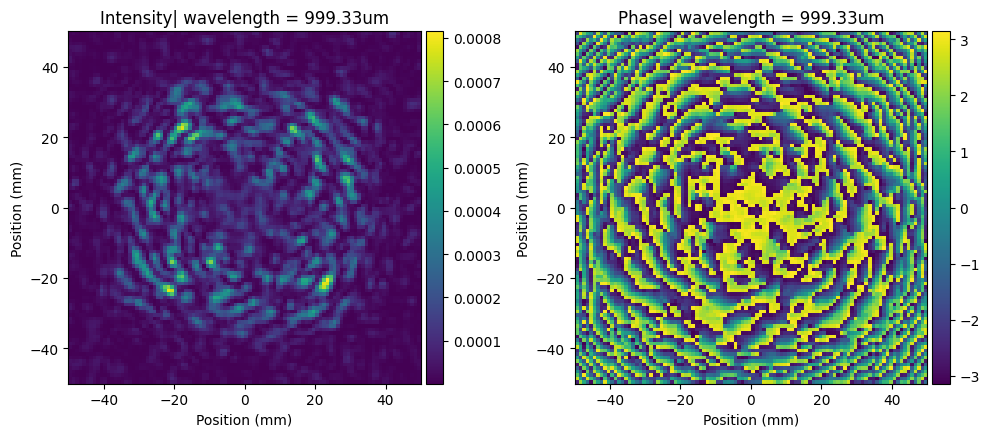

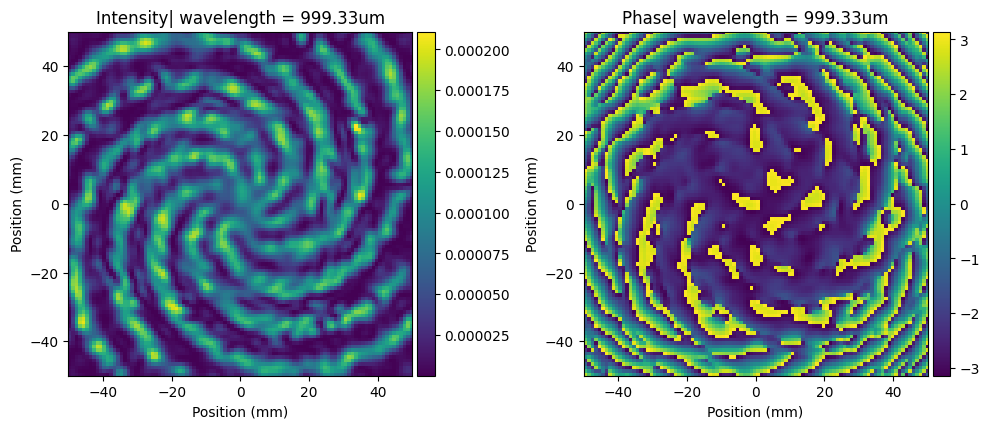

In [18]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

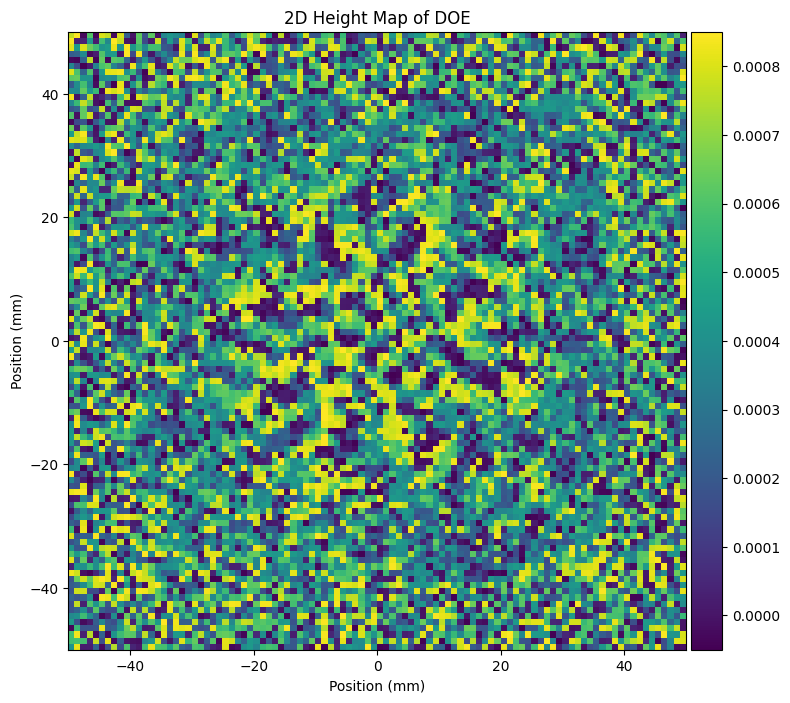

In [19]:
setup.doe.visualize(figsize=(8,8))

# 5. System with PSQuantizedDOELayer

In [20]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = PSQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=250 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [21]:
optim_params = {
    'c_s': 300,
    'tau_max': 800,
    'tau_min': 1
}
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [22]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
optimizer = torch.optim.Adam(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_2, target1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.366178423166275
The iteration : 200, Loss: 0.21893338859081268
The iteration : 400, Loss: 0.20548158884048462
The iteration : 600, Loss: 0.20300644636154175
The iteration : 800, Loss: 0.203730508685112
The iteration : 1000, Loss: 0.20133566856384277
The iteration : 1200, Loss: 0.20387206971645355
The iteration : 1400, Loss: 0.19997182488441467
The iteration : 1600, Loss: 0.20291772484779358
The iteration : 1800, Loss: 0.20147651433944702
The iteration : 2000, Loss: 0.2023521214723587
The iteration : 2200, Loss: 0.20682206749916077
The iteration : 2400, Loss: 0.20234039425849915
The iteration : 2600, Loss: 0.20492993295192719
The iteration : 2800, Loss: 0.2035677134990692
The iteration : 3000, Loss: 0.20293234288692474
The iteration : 3200, Loss: 0.20137271285057068
The iteration : 3400, Loss: 0.2

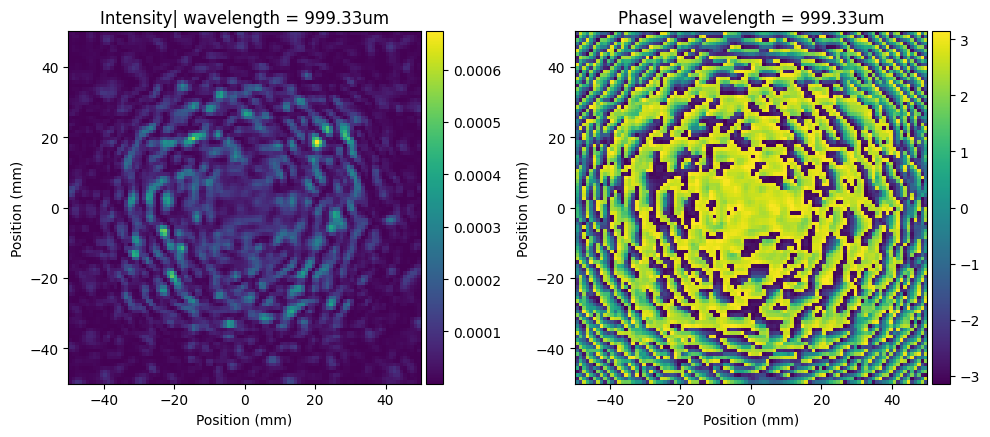

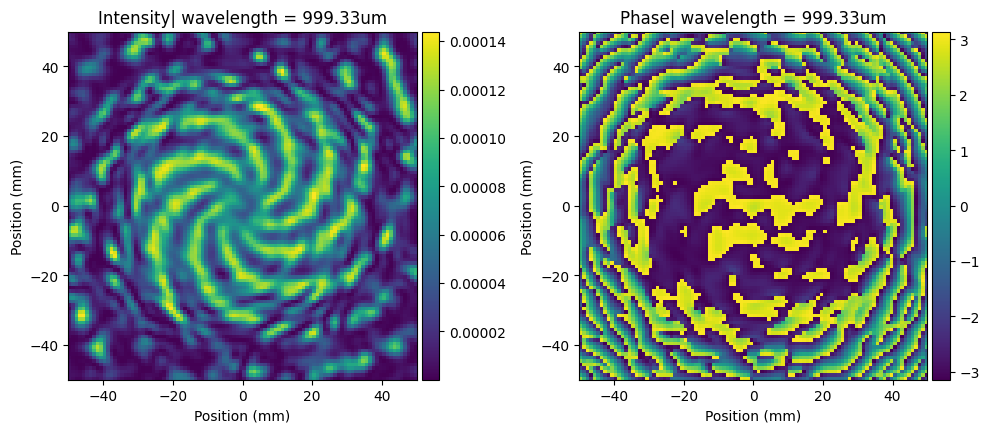

In [23]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

# 6. System with STEQuantizedDOELayer

In [24]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = STEQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=250 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [25]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [26]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
optimizer = torch.optim.Adam(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_2, target1)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.36588114500045776
The iteration : 200, Loss: 0.23298867046833038
The iteration : 400, Loss: 0.18241503834724426
The iteration : 600, Loss: 0.16986142098903656
The iteration : 800, Loss: 0.15011274814605713
The iteration : 1000, Loss: 0.14328821003437042
The iteration : 1200, Loss: 0.1340881735086441
The iteration : 1400, Loss: 0.13093993067741394
The iteration : 1600, Loss: 0.13111823797225952
The iteration : 1800, Loss: 0.12902791798114777
The iteration : 2000, Loss: 0.12367933243513107
The iteration : 2200, Loss: 0.11946335434913635
The iteration : 2400, Loss: 0.12242180854082108
The iteration : 2600, Loss: 0.11133222281932831
The iteration : 2800, Loss: 0.116399385035038
The iteration : 3000, Loss: 0.13214941322803497
The iteration : 3200, Loss: 0.11582247912883759
The iteration : 3400, Loss: 

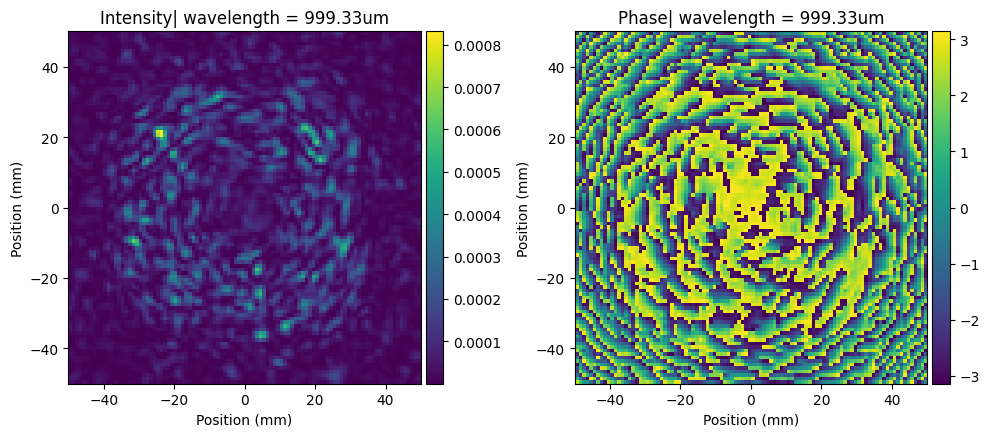

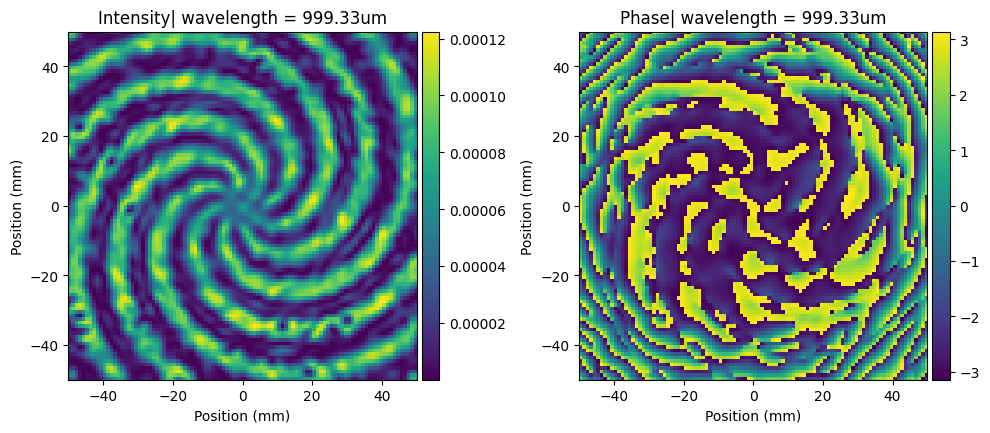

In [27]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)